<h1 align=left><font size = 6>Battle of Neighborhoods in Toronto</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the _k_-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a>

2.  <a href="#item2">Explore Neighborhoods in Toronto</a>

3.  <a href="#item3">Analyze Each Neighborhood</a>

4.  <a href="#item4">Cluster Neighborhoods</a>

5.  <a href="#item5">Examine Clusters</a>  
    </font>
    </div>

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from shapely.geometry import shape, Point
import seaborn as sns

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

<p> Data Source 1: <a href="https://open.toronto.ca/dataset/neighbourhoods/">Neighbourhoods</a>, <a href="https://open.toronto.ca/dataset/neighbourhood-profiles//">Neighbourhoods Profiles</a> </p> 

In [2]:
def toronto_data_request(request_url, request_id):
    # Get the dataset metadata by passing package_id to the package_search endpoint
    # For example, to retrieve the metadata for this dataset:

    url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
    params = { "id": request_id }
    package = requests.get(url, params = params).json()
    # print(package["result"])

    # Get the data by passing the resource_id to the datastore_search endpoint
    # See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
    # For example, to retrieve the data content for the first resource in the datastore:

    for idx, resource in enumerate(package["result"]["resources"]):
        if resource["datastore_active"]:
            url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
            p = { "id": resource["id"], 'limit': 10000 }
            data = requests.get(url, params = p).json()
            df = pd.DataFrame(data["result"]["records"])
            break
    
    return df

In [3]:
request_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
request_id_neighbourhood_profile = "6e19a90f-971c-46b3-852c-0c48c436d1fc"
request_id_neighbourhood = "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"

df_np = toronto_data_request(request_url, request_id_neighbourhood_profile)
df_n = toronto_data_request(request_url, request_id_neighbourhood)

In [4]:
df_np = df_np.loc[[0, 2, 944]].drop(['_id', 'Category', 'Topic', 'Data Source', 'Characteristic', 'City of Toronto'], axis=1).T
df_np.reset_index(inplace=True)
df_np.columns = ['Neighbourhood', 'Code', 'Population 2016', 'Individual Income 2015']

In [5]:
df_n['AREA_SHORT_CODE'] = df_n['AREA_SHORT_CODE'].str.lstrip('0')
df_n = df_n[['AREA_SHORT_CODE', 'geometry', 'Shape__Area']]
df_n.columns = ['Code', 'Geometry', 'Area']

In [8]:
# merge two separate dataframes into one for toronto neighbourhoods
toronto_neighbourhood = pd.merge(df_np, df_n, on='Code')
toronto_neighbourhood['Geometry'] = toronto_neighbourhood['Geometry'].apply(lambda x: json.loads(x))
toronto_neighbourhood['Longitude'] = toronto_neighbourhood['Geometry'].apply(lambda x: shape(x).centroid.x)
toronto_neighbourhood['Latitude'] = toronto_neighbourhood['Geometry'].apply(lambda x: shape(x).centroid.y)
toronto_neighbourhood['Code'] = toronto_neighbourhood['Code'].astype('int')
toronto_neighbourhood['Population 2016'] = toronto_neighbourhood['Population 2016'].apply(lambda x: int(x.replace(",", "")))
toronto_neighbourhood['Individual Income 2015'] = toronto_neighbourhood['Individual Income 2015'].apply(lambda x: int(x.replace(",", "")))
toronto_neighbourhood['Radius'] = toronto_neighbourhood['Area'].apply(lambda x: np.sqrt(x/np.pi))
toronto_neighbourhood.head()

Neighbourhood  Code  Population 2016  \
0               Agincourt North   129            29113   
1  Agincourt South-Malvern West   128            23757   
2                     Alderwood    20            12054   
3                         Annex    95            30526   
4             Banbury-Don Mills    42            27695   

   Individual Income 2015                                           Geometry  \
0                   25005  {'type': 'Polygon', 'coordinates': [[[-79.2421...   
1                   20400  {'type': 'Polygon', 'coordinates': [[[-79.2549...   
2                   10265  {'type': 'Polygon', 'coordinates': [[[-79.5486...   
3                   26295  {'type': 'Polygon', 'coordinates': [[[-79.3941...   
4                   23410  {'type': 'Polygon', 'coordinates': [[[-79.3305...   

           Area  Longitude   Latitude       Radius  
0  1.395145e+07 -79.266712  43.805441  2107.340615  
1  1.511736e+07 -79.265611  43.788657  2193.628289  
2  9.502180e+06 -79.541611  43.604937  1739.148557  
3  5.337192e+06 -79.404000  43.671585  1303.411266  
4  1.924897e+07 -79.349720  43.737658  2475.305272

<p> Data Source 2: <a href="https://foursquare.com/search">Foursquare Search</a>, <a href="https://foursquare.com/developers/apps">Foursquare API</a> </p> 

In [9]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'MPC0L10R1LYKMKHXUY1CWCJQKOVWUPOQOLCZ1M01E4L4O2YN' # your Foursquare ID
CLIENT_SECRET = '5AFGXVDKFJZ5X3FC5G1HODRNABKPJZMQX33WZCLIT3TVUQOH' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [100]:
## create a function to explore all the neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radii):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):
        # print(name)
            
        # create the API request URL & make the GET request
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = {'client_id': CLIENT_ID, 
                  'client_secret': CLIENT_SECRET,
                  'v': VERSION,
                  'section': 'food',
                  'll': '{},{}'.format(lat, lng),
                  'radius': radius,
                  'limit': LIMIT}
        try: 
            results = requests.get(url=url, params=params).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('Find nothing for {}'.format(name))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [101]:
# run the above function on each neighborhood and create a new dataframe
toronto_venues = getNearbyVenues(names=toronto_neighbourhood['Neighbourhood'],
                                 latitudes=toronto_neighbourhood['Latitude'],
                                 longitudes=toronto_neighbourhood['Longitude'],
                                 radii=toronto_neighbourhood['Radius'])
toronto_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Agincourt North               43.805441               -79.266712   
1  Agincourt North               43.805441               -79.266712   
2  Agincourt North               43.805441               -79.266712   
3  Agincourt North               43.805441               -79.266712   
4  Agincourt North               43.805441               -79.266712   

                                       Venue  Venue Latitude  Venue Longitude  \
0   Saravanaa Bhavan South Indian Restaurant       43.810117       -79.269275   
1             Fahmee Bakery & Jamaican Foods       43.810170       -79.280113   
2           Samosa King - Embassy Restaurant       43.810152       -79.257316   
3                                Mona's Roti       43.791613       -79.251015   
4  Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮)       43.797885       -79.270585   

         Venue Category  
0     Indian Restaurant  
1  Caribbean Restaurant  
2     Indian Restaurant  
3  Caribbean Restaurant  
4    Chinese Restaurant

In [11]:
df = pd.merge(toronto_venues, 
              toronto_neighbourhood[['Neighbourhood', 'Code', 'Geometry', 'Population 2016', 'Individual Income 2015']],
              how='left',
              on='Neighbourhood')

In [12]:
mask = df.apply(lambda x: Point(x['Venue Longitude'], x['Venue Latitude']).within(shape(x['Geometry'])), axis=1)
df_new = df[mask][['Neighbourhood', 'Venue', 'Venue Category', 'Population 2016', 'Individual Income 2015']]

In [13]:
df_new.head()

Neighbourhood                                      Venue  \
0   Agincourt North   Saravanaa Bhavan South Indian Restaurant   
1   Agincourt North             Fahmee Bakery & Jamaican Foods   
4   Agincourt North  Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮)   
11  Agincourt North                           Congee Town 太皇名粥   
12  Agincourt North                                     Subway   

          Venue Category  Population 2016  Individual Income 2015  
0      Indian Restaurant            29113                   25005  
1   Caribbean Restaurant            29113                   25005  
4     Chinese Restaurant            29113                   25005  
11    Chinese Restaurant            29113                   25005  
12        Sandwich Place            29113                   25005

## 2. Explore Neighbourhoods in Toronto

In [14]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [15]:
# generate choropleth map 
toronto_geo = 'Neighbourhoods.geojson'

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
map_toronto.choropleth(
    geo_data=toronto_geo,
    data=toronto_neighbourhood,
    columns=['Code', 'Population 2016'],
    key_on='feature.properties.AREA_SHORT_CODE',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population 2016',
    reset=True
)

# display map
map_toronto

## 3. Analyze Each Neighborhood

In [16]:
# one hot encoding
onehot = pd.get_dummies(df_new['Venue Category'])
fixed_columns = list(onehot.columns)

onehot['Neighbourhood'] = df_new['Neighbourhood'] 
onehot['Population'] = df_new['Population 2016'] 
onehot['Income'] = df_new['Individual Income 2015'] 

# move neighborhood column to the first column
onehot = onehot[['Neighbourhood','Population','Income'] + fixed_columns]

# group venues by Neighbourhood and calculate mean (frequency)
onehot_grouped = onehot.groupby(['Neighbourhood','Population','Income']).sum().reset_index()

In [17]:
onehot_grouped.head()

Neighbourhood  Population  Income  Afghan Restaurant  \
0               Agincourt North       29113   25005                  0   
1  Agincourt South-Malvern West       23757   20400                  0   
2                     Alderwood       12054   10265                  0   
3                         Annex       30526   26295                  0   
4             Banbury-Don Mills       27695   23410                  0   

   African Restaurant  American Restaurant  Arepa Restaurant  \
0                   0                    0                 0   
1                   0                    2                 0   
2                   0                    0                 0   
3                   0                    0                 0   
4                   0                    1                 0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  ...  \
0                       0                 0          0  ...   
1                       0                 2          0  ...   
2                       0                 0          0  ...   
3                       0                 1          1  ...   
4                       0                 1          0  ...   

   Tex-Mex Restaurant  Thai Restaurant  Theme Restaurant  Tibetan Restaurant  \
0                   0                0                 0                   0   
1                   0                0                 0                   0   
2                   0                0                 0                   0   
3                   0                1                 0                   0   
4                   0                1                 0                   0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              2   
4                   0                0                              0   

   Vietnamese Restaurant  Wings Joint  Xinjiang Restaurant  
0                      1            0                    0  
1                      1            0                    0  
2                      0            0                    0  
3                      1            0                    0  
4                      0            0                    0  

[5 rows x 117 columns]

#### Let's print each neighborhood along with the top 5 most common venues

In [18]:
# Display top 5 venues in neighbourhoods of interest
num_top_venues = 5

# Analyze top 10 neighbourhoods with the most food venues
onehot_grouped['Total'] = onehot_grouped[fixed_columns].sum(axis=1)
onehot_sorted = onehot_grouped.sort_values(by='Total',ascending=False).head(10)

for hood, pop, incom in zip(onehot_sorted['Neighbourhood'], onehot_sorted['Population'], onehot_sorted['Income']):
    print("----"+hood+"----"+"\n Population: {}, \n Individual Income: {}".format(pop, incom))
    temp = onehot_sorted[fixed_columns][onehot_sorted['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(int)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Milliken----
 Population: 26572, 
 Individual Income: 22380
                 venue  freq
0   Chinese Restaurant    21
1    Korean Restaurant     6
2               Bakery     6
3  Japanese Restaurant     4
4            BBQ Joint     4


----Yorkdale-Glen Park----
 Population: 14804, 
 Individual Income: 12065
                   venue  freq
0             Restaurant     9
1   Fast Food Restaurant     7
2     Italian Restaurant     5
3  Vietnamese Restaurant     4
4         Sandwich Place     4


----York University Heights----
 Population: 27593, 
 Individual Income: 23530
                       venue  freq
0                 Restaurant     7
1             Sandwich Place     7
2                       Café     5
3  Middle Eastern Restaurant     4
4        Japanese Restaurant     4


----Kensington-Chinatown----
 Population: 17945, 
 Individual Income: 16150
                           venue  freq
0                           Café    10
1  Vegetarian / Vegan Restaurant     6
2             

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = onehot_grouped['Neighbourhood']

for ind in np.arange(onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(onehot_grouped[fixed_columns].iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North        Sandwich Place           Pizza Place   
1  Agincourt South-Malvern West    Chinese Restaurant            Restaurant   
2                     Alderwood           Pizza Place            Restaurant   
3                         Annex    Italian Restaurant                  Café   
4             Banbury-Don Mills            Restaurant           Pizza Place   

  3rd Most Common Venue        4th Most Common Venue  \
0    Chinese Restaurant                       Bakery   
1   Japanese Restaurant         Caribbean Restaurant   
2        Sandwich Place                   Donut Shop   
3     Korean Restaurant  Eastern European Restaurant   
4   Japanese Restaurant               Sandwich Place   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Caribbean Restaurant      Sushi Restaurant   Fried Chicken Joint   
1       Cantonese Restaurant   Filipino Restaurant   American Restaurant   
2        Moroccan Restaurant   Xinjiang Restaurant         Deli / Bodega   
3                Pizza Place    Mexican Restaurant            Restaurant   
4  Middle Eastern Restaurant    Italian Restaurant          Burger Joint   

  8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0     Indian Restaurant  Vietnamese Restaurant              Gastropub  
1      Asian Restaurant            Pizza Place                 Bakery  
2                 Diner       Doner Restaurant    Dumpling Restaurant  
3           Salad Place      Indian Restaurant      French Restaurant  
4      Sushi Restaurant                   Café     Chinese Restaurant

## 4. Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

In [21]:
# set number of clusters
kclusters = 5

grouped_clustering = onehot_grouped.drop(['Neighbourhood', 'Population', 'Income', 'Total'], axis=1).astype(float)
grouped_clustering = StandardScaler().fit(grouped_clustering).transform(grouped_clustering)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)

In [22]:
# add clustering labels

onehot_labelled = onehot_grouped.copy()

onehot_labelled.insert(0, 'Cluster Labels', kmeans.labels_)
onehot_labelled = onehot_labelled.merge(toronto_neighbourhood, on='Neighbourhood')
onehot_labelled = onehot_labelled[['Neighbourhood', 'Code', 'Population','Income', 'Cluster Labels', 'Latitude', 'Longitude']]

onehot_labelled.head() # check the last columns!

Neighbourhood  Code  Population  Income  Cluster Labels  \
0               Agincourt North   129       29113   25005               0   
1  Agincourt South-Malvern West   128       23757   20400               1   
2                     Alderwood    20       12054   10265               0   
3                         Annex    95       30526   26295               1   
4             Banbury-Don Mills    42       27695   23410               1   

    Latitude  Longitude  
0  43.805441 -79.266712  
1  43.788657 -79.265611  
2  43.604937 -79.541611  
3  43.671585 -79.404000  
4  43.737658 -79.349720

In [23]:
# generate choropleth map 
toronto_geo = 'Neighbourhoods.geojson'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
onehot_labelled['Population Income'] = onehot_labelled['Population']*onehot_labelled['Income']/1000000


# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(onehot_labelled['Population Income'].min(),
                              onehot_labelled['Population Income'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum


map_clusters.choropleth(
    geo_data=toronto_geo,
    data=onehot_labelled,
    columns=['Code', 'Population Income'],
    threshold_scale=threshold_scale,
    key_on='feature.properties.AREA_SHORT_CODE',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Income (Millions)',
    reset=True
)


In [24]:

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lng, name, code, cluster in zip(onehot_labelled['Latitude'], 
                                   onehot_labelled['Longitude'], 
                                   onehot_labelled['Neighbourhood'], 
                                   onehot_labelled['Code'],
                                   onehot_labelled['Cluster Labels']):
    label = folium.Popup('{} ({}):'.format(name, code) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
dists = euclidean_distances(kmeans.cluster_centers_)
dists

array([[ 0.        ,  6.09270597, 30.5611725 , 18.87345448, 22.89097492],
       [ 6.09270597,  0.        , 29.33058632, 17.81289516, 22.06452196],
       [30.5611725 , 29.33058632,  0.        , 34.69020594, 36.43647529],
       [18.87345448, 17.81289516, 34.69020594,  0.        , 24.97770734],
       [22.89097492, 22.06452196, 36.43647529, 24.97770734,  0.        ]])

In [26]:
df_analysis = onehot_labelled.drop(['Latitude', 'Longitude'], axis=1).merge(neighborhoods_venues_sorted, on='Neighbourhood').merge(onehot_grouped[['Neighbourhood', 'Total']], on='Neighbourhood')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

[Text(0.5, 0, 'Population'), Text(0, 0.5, 'No. of Neighbourhoods')]

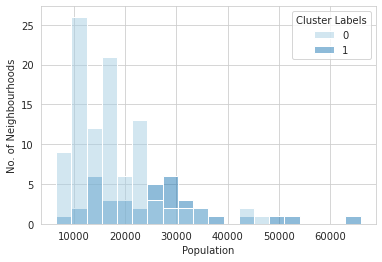

In [70]:
sns.set_style("whitegrid")

ax1 = sns.histplot(data=df_analysis[df_analysis['Cluster Labels'].isin([0,1])], x='Population', hue='Cluster Labels', palette='Paired', bins=20)
ax1.set(xlabel='Population', ylabel='No. of Neighbourhoods')

[Text(0.5, 0, 'Average Annual Income (CAD)'),
 Text(0, 0.5, 'No. of Neighbourhoods')]

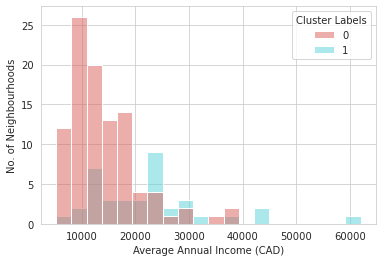

In [71]:
ax2 = sns.histplot(data=df_analysis[df_analysis['Cluster Labels'].isin([0,1])], x='Income', hue='Cluster Labels', palette='hls', bins=20)
ax2.set(xlabel='Average Annual Income (CAD)', ylabel='No. of Neighbourhoods')

In [72]:
df_analysis[df_analysis['Cluster Labels']==0].sort_values(by='Total', ascending=False)

Neighbourhood  Code  Population  Income  \
46                     Greenwood-Coxwell    65       14417   11915   
52                     Hillcrest Village    48       16934   14800   
86                      Newtonbrook West    36       23831   20820   
97              Playter Estates-Danforth    67        7804    6490   
82                   Mount Pleasant East    99       16775   13780   
9                   Bedford Park-Nortown    39       23236   18560   
50                     High Park-Swansea    87       23925   19810   
113                  Stonegate-Queensway    16       25051   20830   
137                       Yonge-St.Clair    97       12528   11170   
28                              Danforth    66        9666    7950   
49                       High Park North    88       22162   18980   
123                            West Hill   136       27392   22395   
104                  Rosedale-Moore Park    98       20923   18000   
7                        Bayview Village    52       21396   18730   
84                           New Toronto    18       11463    9670   
105                                Rouge   131       46496   38125   
77   Mimico (includes Humber Bay Shores)    17       33964   29830   
67                      Lansing-Westgate    38       16164   13645   
85                      Newtonbrook East    50       16097   13950   
48                            Henry Farm    53       15723   13210   
89                  North St. James Town    74       18615   16075   
19      Cabbagetown-South St. James Town    71       11669   10195   
18                   Brookhaven-Amesbury    30       17757   14350   
109                       South Parkdale    85       21849   18595   
112                              Steeles   116       24623   21120   
72                           Long Branch    19       10084    8725   
121                     Victoria Village    43       17510   14550   
25                          Clanton Park    33       16472   13660   
70                    Leaside-Bennington    56       16828   13360   
40        Eringate-Centennial-West Deane    11       18588   15895   
93                         Old East York    58        9233    7740   
95                     Parkwoods-Donalda    45       34805   28900   
64                        Kingsway South    15        9271    7590   
43                     Forest Hill North   102       12806   10615   
54                         Humber Summit    21       12416   10255   
111                 St.Andrew-Windfields    40       17812   15040   
0                        Agincourt North   129       29113   25005   
39                   Englemount-Lawrence    32       22372   17085   
17                       Broadview North    57       11499    9880   
37                         Eglinton East   138       22776   18075   
73                               Malvern   132       43794   35865   
90                     O'Connor-Parkview    54       18675   15400   
106         Runnymede-Bloor West Village    89       10070    8020   
117         Thistletown-Beaumond Heights     3       10360    8395   
126                               Weston   113       17992   14605   
42                       Flemingdon Park    44       21933   17535   
92                       Oakwood Village   107       21210   17840   
14                           Blake-Jones    69        7727    6280   
16     Bridle Path-Sunnybrook-York Mills    41        9266    7745   
15                  Briar Hill-Belgravia   108       14257   12360   
45                Glenfield-Jane Heights    25       30491   24430   
34                        Dufferin Grove    83       11785   10430   
55                            Humbermede    22       15545   12585   
5                         Bathurst Manor    34       15873   13270   
108                  Scarborough Village   139       16724   13080   
21                             Casa Loma    96       10968    9590   
12                 Birchcliffe-Cliffs

In [315]:
df_analysis[df_analysis['Cluster Labels']==1].sort_values(by='Total', ascending=False)

Neighbourhood  Code  Population  Income  \
76                              Milliken   130       26572   22380   
139                   Yorkdale-Glen Park    31       14804   12065   
138              York University Heights    27       27593   23530   
58            Islington-City Centre West    14       43965   37410   
6                    Bay Street Corridor    76       25797   23945   
124               West Humber-Clairville     1       33312   27850   
1           Agincourt South-Malvern West   128       23757   20400   
4                      Banbury-Don Mills    42       27695   23410   
110                      South Riverdale    70       27876   23140   
103                         Roncesvalles    86       14974   12565   
71                       Little Portugal    84       15559   13660   
129                      Willowdale East    51       50434   44340   
128                     Wexford/Maryvale   119       27917   23330   
122    Waterfront Communities-The Island    77       65913   61985   
135                             Wychwood    94       14349   11345   
116                          The Beaches    63       21567   17615   
3                                  Annex    95       30526   26295   
32   Dovercourt-Wallace Emerson-Junction    93       36625   31825   
114               Tam O'Shanter-Sullivan   118       27446   23140   
23                 Church-Yonge Corridor    75       31340   29085   
31                           Dorset Park   126       25003   20130   
79                             Moss Park    73       20506   17025   
24                   Clairlea-Birchmount   120       26984   21740   
88                       North Riverdale    68       11916    9740   
94               Palmerston-Little Italy    80       13826   12495   
120                           University    79        7607    6170   
130                      Willowdale West    37       16936   14935   
27                Corso Italia-Davenport    92       14133   12175   
11                               Bendale   127       29960   24610   
119                    Trinity-Bellwoods    81       16556   14490   
132                               Woburn   137       53485   43410   
30                    Don Valley Village    47       27051   22760   
87                               Niagara    82       31180   28390   
136                       Yonge-Eglinton   100       11817    9995   
118                     Thorncliffe Park    55       21108   15250   
68                   Lawrence Park North   105       14607   11280   
33                  Downsview-Roding-CFB    26       35052   29220   
35                     East End-Danforth    62       21381   17290   

     Cluster Labels  1st Most Common Venue  2nd Most Common Venue  \
76                1     Chinese Restaurant      Korean Restaurant   
139               1             Restaurant   Fast Food Restaurant   
138               1             Restaurant         Sandwich Place   
58                1             Restaurant           Burger Joint   
6                 1       Sushi Restaurant    Japanese Restaurant   
124               1             Restaurant    American Restaurant   
1                 1     Chinese Restaurant             Restaurant   
4                 1             Restaurant            Pizza Place   
110               1                 Bakery  Vietnamese Restaurant   
103               1             Restaurant                 Bakery   
71                1                   Café             Restaurant   
129               1            Pizza Place   Fast Food Restaurant   
128               1            Pizza Place      Indian Restaurant   
122               1                   Café                 Bakery   
135               1                   Café                 Bakery   
116               1            Pizza Place                   Café   
3                 1     Italian Restaurant                   Café   
32                1                   Café            

In [318]:
df_analysis[df_analysis['Cluster Labels']==2].sort_values(by='Total', ascending=False)

Neighbourhood  Code  Population  Income  Cluster Labels  \
62  Kensington-Chinatown    78       17945   16150               2   

   1st Most Common Venue          2nd Most Common Venue 3rd Most Common Venue  \
62                  Café  Vegetarian / Vegan Restaurant                Bakery   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
62  Caribbean Restaurant    Mexican Restaurant   Japanese Restaurant   

   7th Most Common Venue    8th Most Common Venue 9th Most Common Venue  \
62          Burger Joint  Comfort Food Restaurant      Sushi Restaurant   

   10th Most Common Venue  Total  
62    Dumpling Restaurant     67

In [317]:
df_analysis[df_analysis['Cluster Labels']==3].sort_values(by='Total', ascending=False)

Neighbourhood  Code  Population  Income  Cluster Labels  \
59  Junction Area    90       14366   12010               3   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
59                Bakery                  Café  Fast Food Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
59       Thai Restaurant           Pizza Place        Sandwich Place   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
59            Restaurant     Indian Restaurant    Mexican Restaurant   

   10th Most Common Venue  Total  
59              BBQ Joint     59

In [316]:
df_analysis[df_analysis['Cluster Labels']==4].sort_values(by='Total', ascending=False)

Neighbourhood  Code  Population  Income  Cluster Labels  \
83  Mount Pleasant West   104       29658   26550               4   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
83           Pizza Place    Italian Restaurant  Fast Food Restaurant   

        4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
83  Middle Eastern Restaurant     Indian Restaurant         Deli / Bodega   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
83      Sushi Restaurant            Restaurant                  Café   

   10th Most Common Venue  Total  
83         Sandwich Place     57